In [36]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np

In [37]:
# Loading the dataset

df = pd.read_csv('Apache_2k_modified.csv')

In [38]:
df.head()

,LineId,Time,Level,Content,EventId,EventTemplate
0,1,Sun Dec 04 04:47:44 2005,notice,workerEnv.init() ok /etc/httpd/conf/workers2.p...,workerEnv.init\(\) ok <*>,workerEnv.init() ok <*>
1,2,Sun Dec 04 04:47:44 2005,error,mod_jk child workerEnv in error state 6,mod_jk child workerEnv in error state <*>,mod_jk child workerEnv in error state <*>
2,3,Sun Dec 04 04:51:08 2005,notice,jk2_init() Found child 6725 in scoreboard slot 10,jk2_init\(\) Found child <*> in scoreboard slo...,jk2_init() Found child <*> in scoreboard slot <*>
3,4,Sun Dec 04 04:51:09 2005,notice,jk2_init() Found child 6726 in scoreboard slot 8,jk2_init\(\) Found child <*> in scoreboard slo...,jk2_init() Found child <*> in scoreboard slot <*>
4,5,Sun Dec 04 04:51:09 2005,notice,jk2_init() Found child 6728 in scoreboard slot 6,jk2_init\(\) Found child <*> in scoreboard slo...,jk2_init() Found child <*> in scoreboard slot <*>


In [39]:
df.isnull().sum()

LineId           0
Time             0
Level            0
Content          0
EventId          0
EventTemplate    0
dtype: int64

In [40]:
len(df)

2000

In [41]:
df = df.drop_duplicates()

In [42]:
len(df)

2000

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score, roc_curve, auc
import matplotlib.pyplot as plt

In [44]:
label_encoder = LabelEncoder()
df['Level_encoded'] = label_encoder.fit_transform(df['Level'])

In [45]:
tfidf = TfidfVectorizer(max_features=100)
content_tfidf = tfidf.fit_transform(df['Content']).toarray()
X = np.hstack((df[['Level_encoded']].values, content_tfidf))

In [46]:
iso_labels = IsolationForest(contamination=0.05, random_state=42).fit_predict(X)

In [47]:
# Define base models
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
ocsvm = OneClassSVM(gamma='scale', nu=0.1)

In [48]:
# Convert base learner predictions for stacking
iso_preds = iso_forest.fit_predict(X)
lof_preds = lof.fit_predict(X)
ocsvm_preds = ocsvm.fit_predict(X)
stacked_features = np.vstack((iso_preds, lof_preds, ocsvm_preds)).T

/home/kairaj5456/.local/bin/new/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


In [49]:
# Meta-learner (logistic Regression)

meta_model = LogisticRegression()
meta_model.fit(stacked_features, iso_labels)
stacking_preds = meta_model.predict(stacked_features)

Anomalies detected: 108 out of 2000
Shape of anomaly points: (108, 101)
Shape of normal points: (1892, 101)


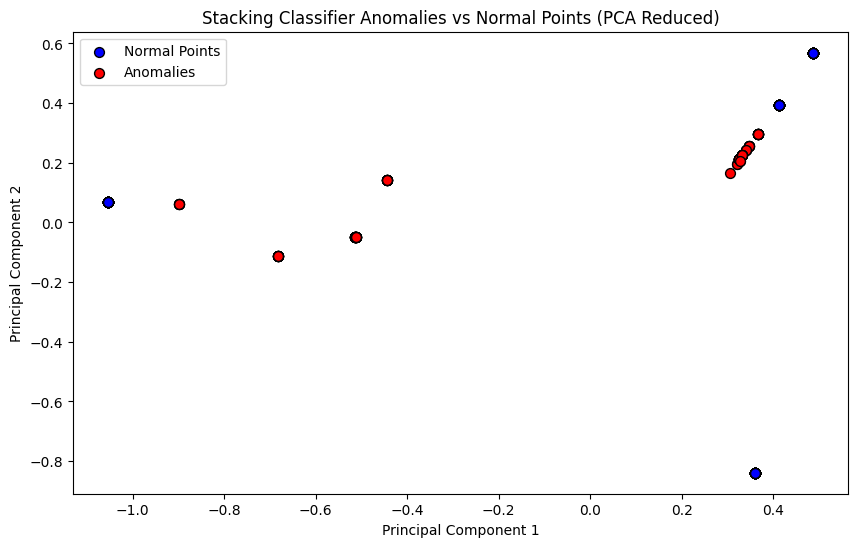

In [50]:
# Separate anomalies and normal points
anomaly_points = X[stacking_preds == -1]
normal_points = X[stacking_preds == 1]

# Count anomalies detected out of 2000
anomalies_count = np.sum(stacking_preds == -1)
print(f"Anomalies detected: {anomalies_count} out of 2000")

# Check the shapes of anomaly and normal points
print(f"Shape of anomaly points: {anomaly_points.shape}")
print(f"Shape of normal points: {normal_points.shape}")

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Separate the reduced features for normal and anomaly points
normal_points_pca = X_pca[stacking_preds == 1]
anomaly_points_pca = X_pca[stacking_preds == -1]

# Visualize the results
plt.figure(figsize=(10, 6))

# Plot normal points in blue
plt.scatter(normal_points_pca[:, 0], normal_points_pca[:, 1], c='blue', edgecolors='k', s=50, label='Normal Points')

# Plot anomaly points in red
plt.scatter(anomaly_points_pca[:, 0], anomaly_points_pca[:, 1], c='red', edgecolors='k', s=50, label='Anomalies')

# Set title and labels
plt.title("Stacking Classifier Anomalies vs Normal Points (PCA Reduced)")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


In [55]:
labels_combined = [1 if p == 1 else 0 for p in stacking_preds]  # Label anomalies as 0, normal points as 1

# Calculate silhouette score if there are at least 2 distinct labels
if len(set(labels_combined)) > 1:
    silhouette_final = silhouette_score(X, labels_combined)
    print(f"Silhouette Score for Stacking Model: {silhouette_final}")
else:
    print("Silhouette score cannot be calculated because there is only one class.")

Silhouette Score for Stacking Model: 0.23577995486171902
